In [1]:
import pandas as pd
import os
import json
from scipy.io import wavfile
import glob
from pydub import AudioSegment
from pydub.playback import play
from IPython.display import Audio
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
import librosa
from sklearn.model_selection import train_test_split
import wave
import matplotlib.pyplot as plt
import librosa.display

C:\Users\drake\anaconda3\envs\tf\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Preprocessing

Load Data, going to try out Mel-frequency cepstral coefficients (MFCCs) and spectrograms
Then split data into train test split. (Hopefully will use a nested cross val)

In [2]:
df = pd.read_csv('cough_data.csv')
df.head()

,cough_detected,age,is_female,is_male,COVID-19,symptomatic,season_autumn,season_spring,season_summer,Africa,Asia,Europe,North America,Oceania,South America,file_path,wav_file_name
0,0.6911,31,1,0,0,1,0,1,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,00432f00-2477-4faf-a440-cc1276065b4a.wav
1,0.9751,44,0,1,0,1,0,1,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,008c1c9e-aeef-40c5-846c-24f1b964f884.wav
2,0.9775,17,0,1,0,1,1,0,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,00ac8cb0-3384-46b2-9db5-5b5e911615f0.wav
3,0.9900,41,1,0,0,1,0,1,0,0,0,0,0,0,1,C:\Users\drake\Documents\DL Machine Learning C...,00ce5b06-c302-4387-bbd7-86355a4a8c12.wav
4,0.9632,39,1,0,1,0,1,0,0,0,0,1,0,0,0,C:\Users\drake\Documents\DL Machine Learning C...,01424527-9c3b-4b6e-96f1-9eea3150819b.wav


In [3]:
print(df.loc[2,'file_path'])

C:\Users\drake\Documents\DL Machine Learning Class\Final\coughvid_dataset\00ac8cb0-3384-46b2-9db5-5b5e911615f0.wav


In [4]:
# right now I am going to drop every columns besides 
# COVID-19 (target variable) and File_path (feature/ has the audio wav file)
df = df.drop(columns=[col for col in df.columns if col not in ['COVID-19',
                                                               'file_path']])
df.head(1)

,COVID-19,file_path
0,0,C:\Users\drake\Documents\DL Machine Learning C...


In [5]:
df['COVID-19'].value_counts()

0    1524
1     620
Name: COVID-19, dtype: int64

In [6]:
# setting up features and target variable
X = df.drop('COVID-19',axis=1)
y = df['COVID-19']

# Oversampling since we have few actual covid cases
from imblearn.over_sampling import RandomOverSampler

X_resampled, y_resampled = RandomOverSampler().fit_resample(X, y)

In [7]:
X_resampled.head()

,file_path
0,C:\Users\drake\Documents\DL Machine Learning C...
1,C:\Users\drake\Documents\DL Machine Learning C...
2,C:\Users\drake\Documents\DL Machine Learning C...
3,C:\Users\drake\Documents\DL Machine Learning C...
4,C:\Users\drake\Documents\DL Machine Learning C...


In [8]:
y_resampled.head()

0    0
1    0
2    0
3    0
4    1
Name: COVID-19, dtype: int64

In [9]:
y_resampled.value_counts()

0    1524
1    1524
Name: COVID-19, dtype: int64

In [10]:
pd.set_option('display.max_colwidth', 1000)
X_resampled.iloc[0]

file_path    C:\Users\drake\Documents\DL Machine Learning Class\Final\coughvid_dataset\00432f00-2477-4faf-a440-cc1276065b4a.wav
Name: 0, dtype: object

In [11]:
# going to play these audio clips using librosa

# Load the audio data using librosa
audio_data, sr = librosa.load(X_resampled.loc[12, 'file_path'])

# Play the audio using IPython.display.Audio
Audio(audio_data, rate=sr)

# Trim 2 Seconds of empty audio space from each audio file

In [12]:
# Only need to run this below code once

In [13]:
fixed_length = 8 # seconds
silence_duration = 2 # seconds

for index, row in X_resampled.iterrows():
    audio_file_path = row['file_path']
    audio, sr = librosa.load(audio_file_path, sr=None, mono=True)

    # Compute the frame size and hop size in samples
    frame_size = int(sr * silence_duration)
    hop_size = int(frame_size / 2)

    # Trim leading and trailing silence
    audio, _ = librosa.effects.trim(audio, top_db=30, frame_length=frame_size, hop_length=hop_size)

    # If audio is shorter than 8 seconds, pad with zeros
    target_length = int(sr * fixed_length)
    if len(audio) < target_length:
        padded_audio = np.zeros(target_length)
        padded_audio[:len(audio)] = audio
        audio = padded_audio
    else:
        # Truncate to fixed length
        audio = audio[:target_length]

    # Save the processed audio to file
    import soundfile as sf
    sf.write(audio_file_path, audio, sr)


# Wave Form images
Now that the duration of all my .wav audio files are 10 seconds. I am going to see what they look like

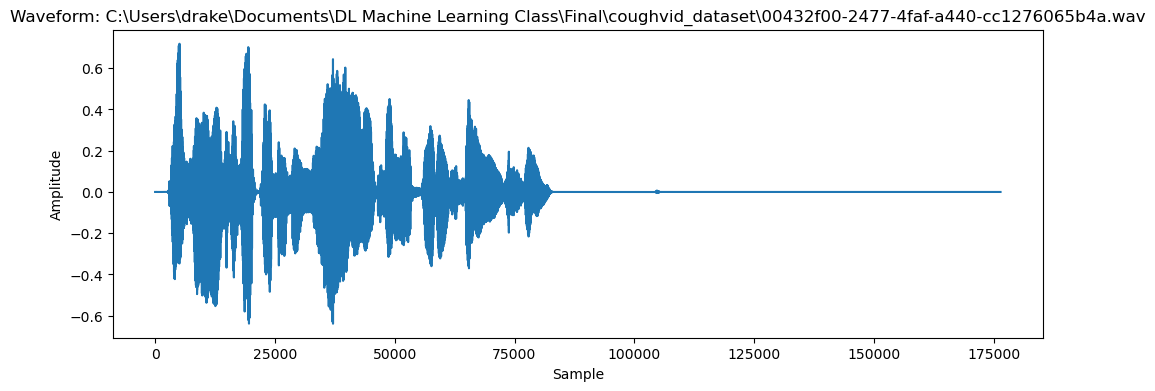

In [17]:
# Load the desired audio file
y, sr = librosa.load(X_resampled.loc[4, 'file_path'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title('Waveform: ' + X_resampled.loc[0, 'file_path'])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

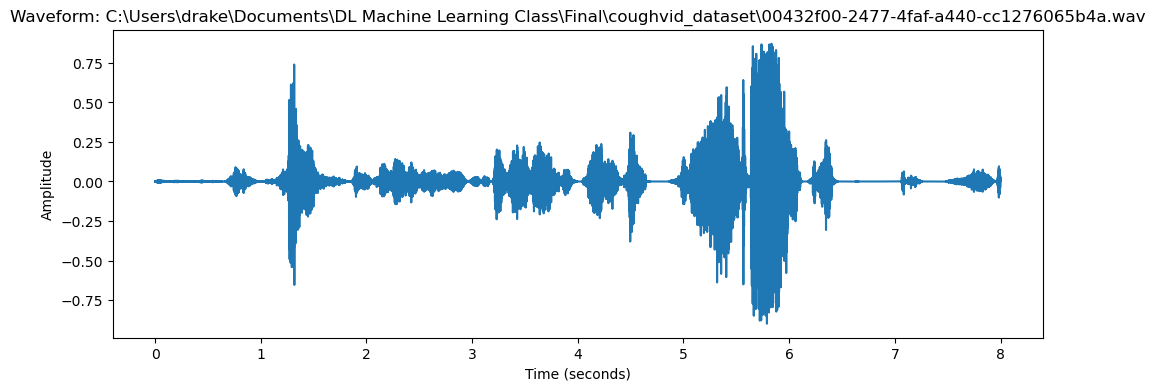

In [18]:
# Load the desired audio file
y, sr = librosa.load(X_resampled.loc[0, 'file_path'])

# Plot waveform
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(y))/sr, y)
plt.title('Waveform: ' + X_resampled.loc[0, 'file_path'])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()


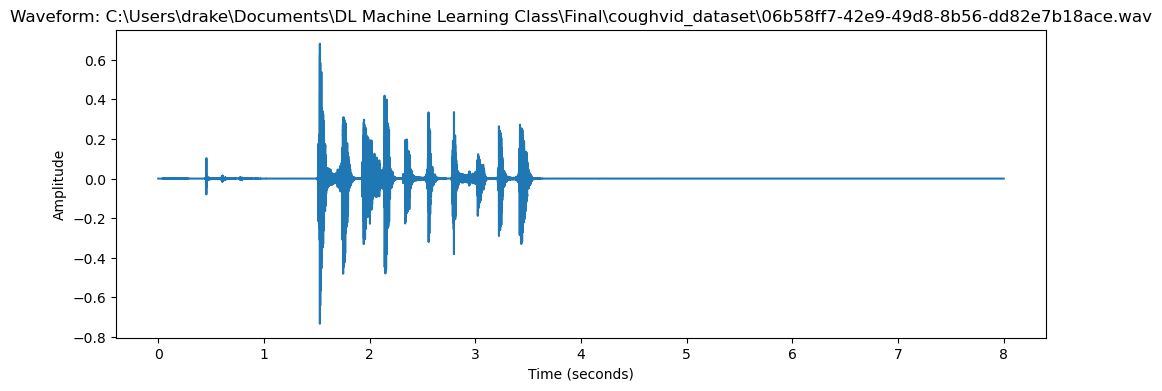

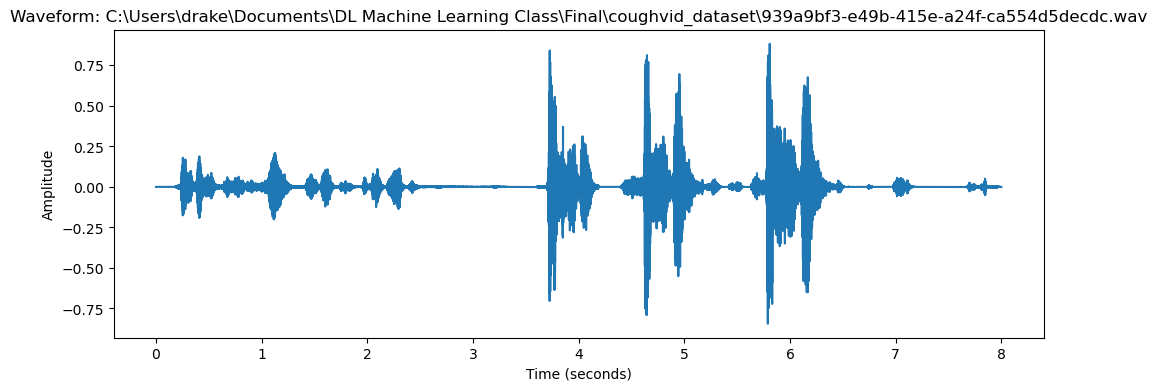

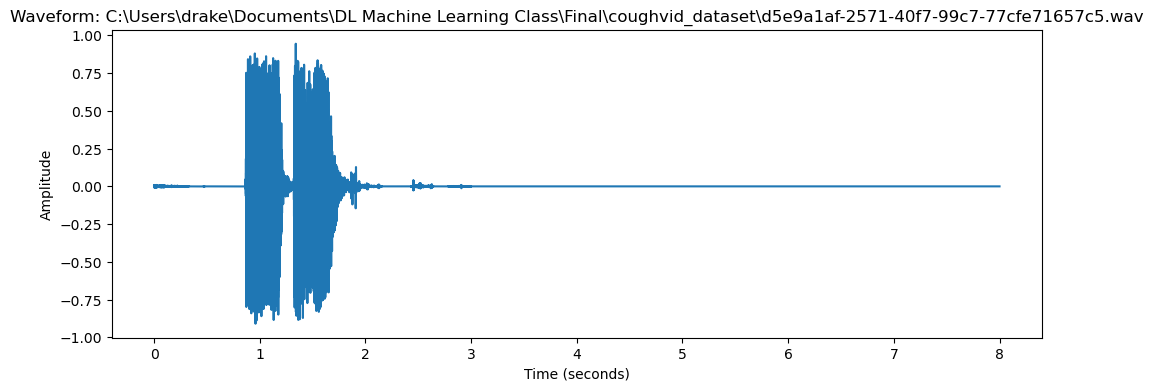

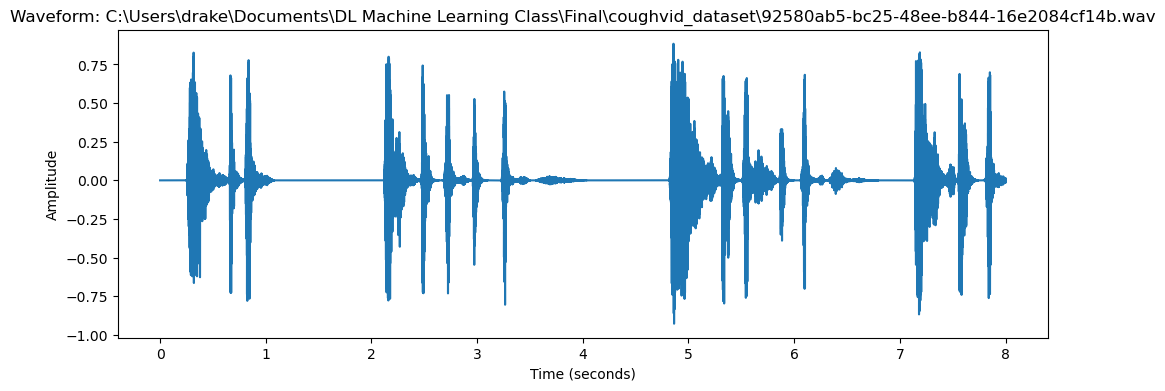

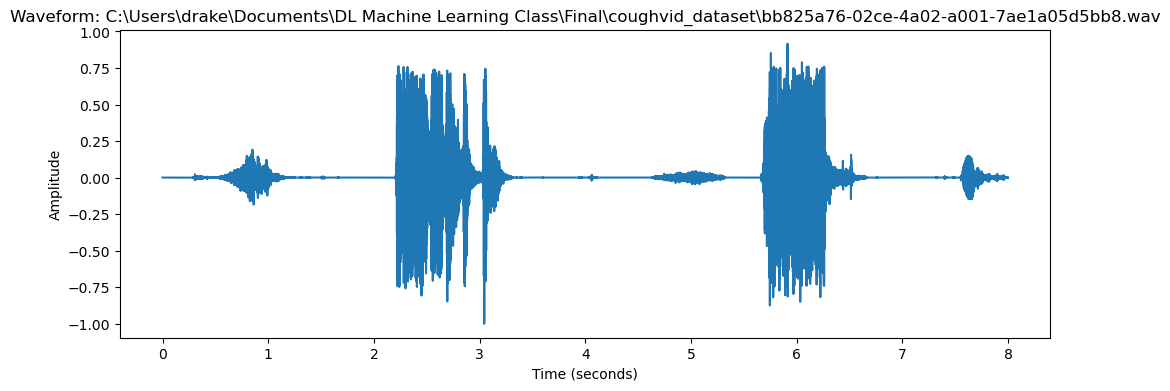

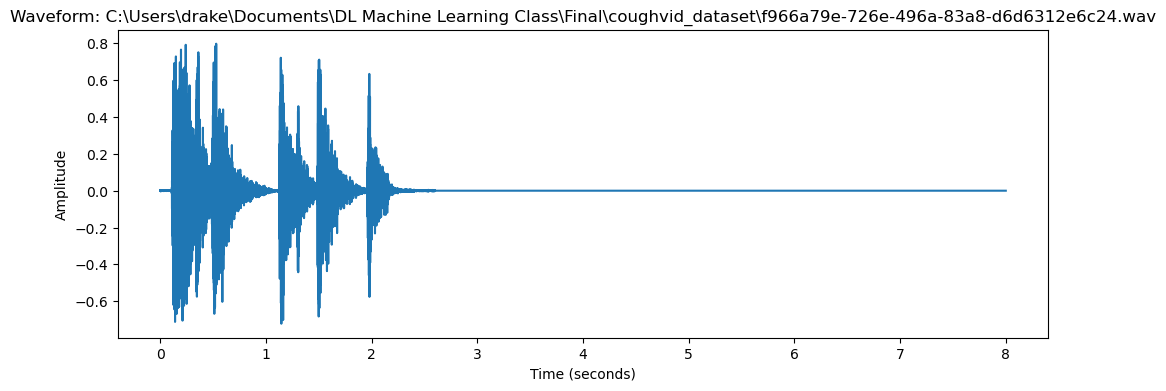

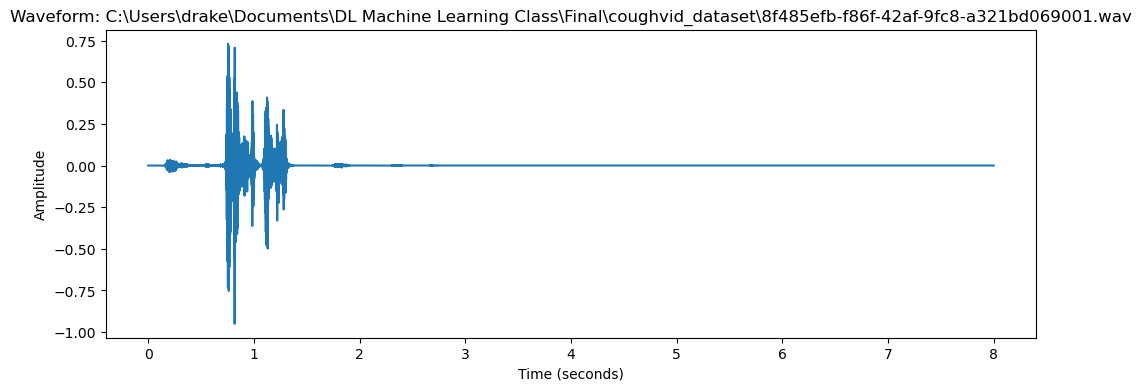

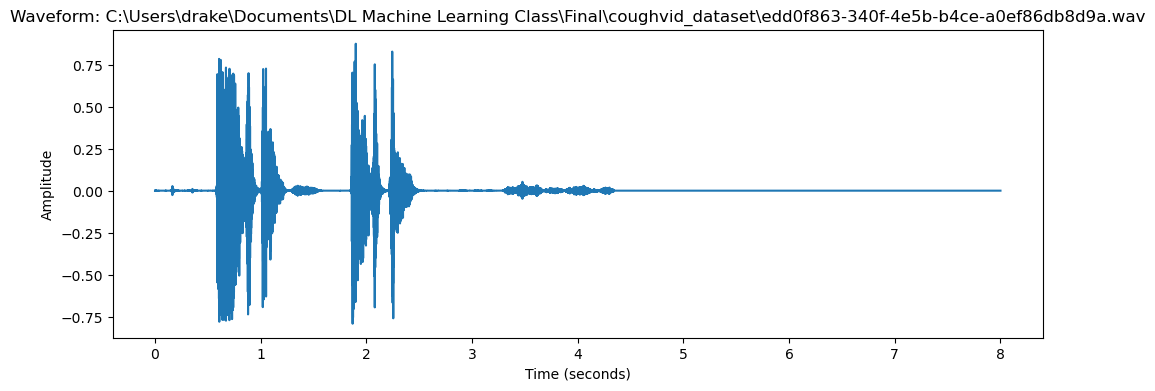

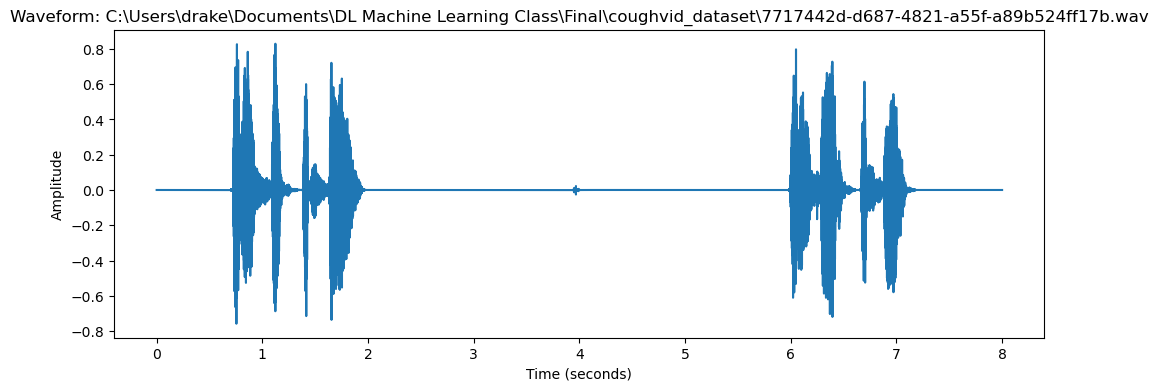

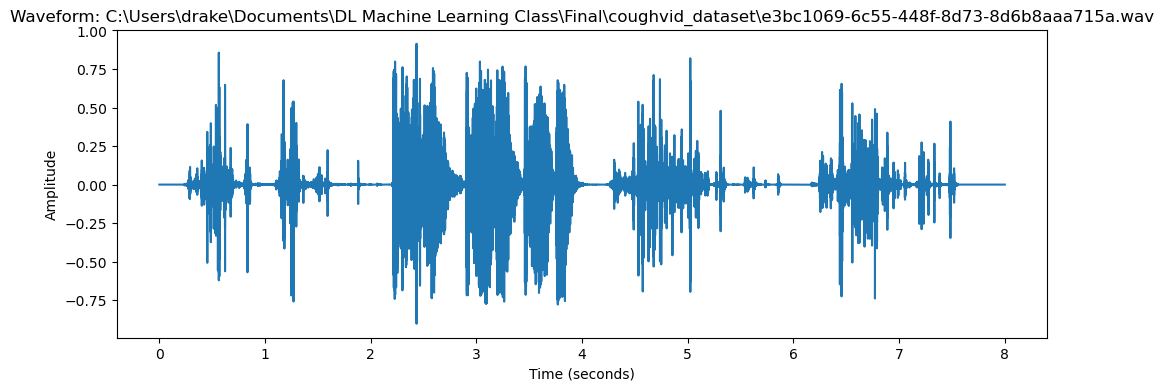

In [19]:
# This code will show me 10 random audio forms from my dataset. 
# I am going to do this a bunch of times just to look at the .wav files
# I plan on using librosa to truncate 2 invisible seconds in each clip
# to see if that helps with performance
import random

# Select 10 random audio files from X_resampled
random_files = random.sample(X_resampled['file_path'].tolist(), 10)

# Loop through the random files and plot their waveforms
for file_path in random_files:
    y, sr = librosa.load(file_path)
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(len(y))/sr, y)
    plt.title('Waveform: ' + file_path)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.show()


# Mel Frequency Cepstral Coefficients (MFCCs)
## 8k Hz

In [20]:
# Reshaping Splits so they can fit in CNN Model

In [21]:
# Define the desired number of MFCC coefficients, time steps and frequency bins
sr = 8000
n_mfcc = 13
hop_length = 512
time_steps = int(10 * sr / hop_length)

# Define a function to extract features from audio files
def extract_features(file_path):
    audio_file, sr = librosa.load(file_path, sr=8000)
    mfccs = librosa.feature.mfcc(y=audio_file, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
    return mfccs

# Apply the function to all audio files in the X_resampled dataframe
X_mfccs = X_resampled['file_path'].apply(extract_features)

# Pad or truncate the MFCCs to the desired number of time steps
X_mfccs_padded = []
for mfccs in X_mfccs:
    if mfccs.shape[1] < time_steps:
        padded_mfccs = np.pad(mfccs.T, ((0, time_steps - mfccs.shape[1]), (0, 0)), mode='constant')
        X_mfccs_padded.append(padded_mfccs[:time_steps, :])
    else:
        X_mfccs_padded.append(mfccs.T[:time_steps, :])
X_mfccs = np.array(X_mfccs_padded)

In [22]:
print("X_mfccs shape:", X_mfccs.shape)

X_mfccs shape: (3048, 156, 13)


# Train Test Val Split

In [23]:
from sklearn.model_selection import train_test_split
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mfccs, y_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [24]:
# Shape
# Print the shapes of the resulting data splits
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1828, 156, 13)
y_train shape: (1828,)
X_val shape: (610, 156, 13)
y_val shape: (610,)
X_test shape: (610, 156, 13)
y_test shape: (610,)


In [25]:
# Have to reshape into 4d to be able to run in a CNN model
import numpy as np

# Reshape input data to add an additional dimension
X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

# Check the new shape of the input data
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)


X_train shape: (1828, 156, 13, 1)
X_val shape: (610, 156, 13, 1)
X_test shape: (610, 156, 13, 1)


# CNN Model

In [26]:
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
input_shape = (156, 13, 1) # Example input shape
num_classes = 10

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=(1,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))
32

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [29]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
58/58 [==============================] - 3s 39ms/step - loss: 2.6704 - accuracy: 0.2588 - val_loss: 6.2559 - val_accuracy: 0.0180
Epoch 2/50
58/58 [==============================] - 2s 39ms/step - loss: 1.5738 - accuracy: 0.5109 - val_loss: 1.7812 - val_accuracy: 0.5443
Epoch 3/50
58/58 [==============================] - 2s 40ms/step - loss: 1.0030 - accuracy: 0.6258 - val_loss: 1.1220 - val_accuracy: 0.5393
Epoch 4/50
58/58 [==============================] - 2s 38ms/step - loss: 0.7636 - accuracy: 0.6570 - val_loss: 0.7224 - val_accuracy: 0.6311
Epoch 5/50
58/58 [==============================] - 2s 37ms/step - loss: 0.6834 - accuracy: 0.6734 - val_loss: 0.6910 - val_accuracy: 0.6541
Epoch 6/50
58/58 [==============================] - 2s 36ms/step - loss: 0.6186 - accuracy: 0.6991 - val_loss: 0.6630 - val_accuracy: 0.6492
Epoch 7/50
58/58 [==============================] - 2s 40ms/step - loss: 0.5817 - accuracy: 0.7199 - val_loss: 0.6753 - val_accuracy: 0.6328
Epoch 8/50
58

# Test Split Scores

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 [==============================] - 0s 15ms/step - loss: 0.7731 - accuracy: 0.7885
Test Loss: 0.7731
Test Accuracy: 0.7885


In [31]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Classification Report

In [32]:
# predict probabilities for test data
y_prob = model.predict(X_test)

# get predicted labels
y_pred = y_prob.argmax(axis=-1)

# generate classification report
report = classification_report(y_test, y_pred)
print(report)

20/20 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       314
           1       0.77      0.80      0.79       296
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.79       610
   macro avg       0.40      0.39      0.39       610
weighted avg       0.79      0.79      0.79       610



C:\Users\drake\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drake\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drake\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Auc Roc

In [33]:
# Compute and print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score:', roc_auc)

ROC AUC score: 0.7896529092787055


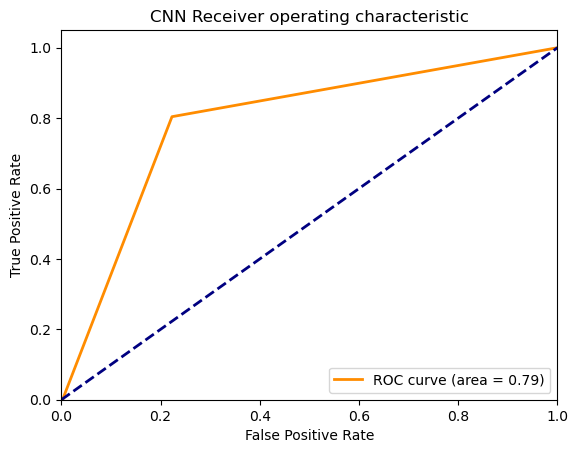

In [34]:
# auc roc graph
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Confusion Matrix

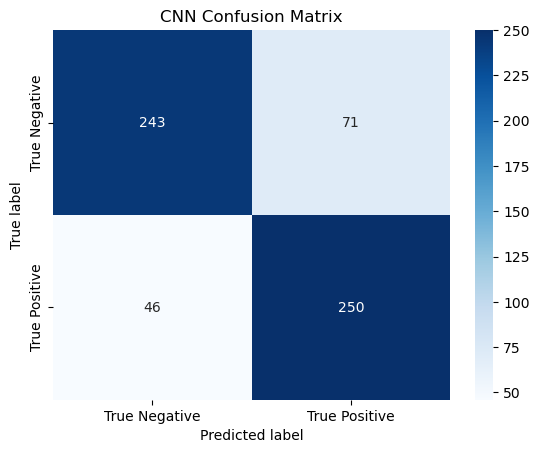

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the confusion matrix
cm = np.array([[243, 71], [46, 250]])

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['True Negative', 'True Positive'], yticklabels=['True Negative', 'True Positive'])

# Set the axis labels and title
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('CNN Confusion Matrix')

# Display the plot
plt.show()
